# Getting Started with `bw_timex`

Here's a rundown of the steps involved in a `TimexLCA`:

<div style="display: flex; justify-content: center; background-color: white; border-radius: 15px; padding: 10px; width: 45%; margin: auto;">
  <img src="data/method.svg" style="border-radius: 15px; width: 100%;">
</div>

Let's walk through steps 1-4 considering a very simple dummy system:

```mermaid

flowchart LR
subgraph background[<i>background</i>]
    B(Process B):::bg
end

subgraph foreground[<i>foreground</i>]
    A(Process A):::fg
end

subgraph biosphere[<i>biosphere</i>]
    CO2(CO2):::bio
end

B-->|"3 kg"|A
A-.->|"5 kg"|CO2
B-.->|"11 kg"|CO2

classDef fg color:#222832, fill:#3fb1c5, stroke:none;
classDef bg color:#222832, fill:#3fb1c5, stroke:none;
classDef bio color:#222832, fill:#9c5ffd, stroke:none;
style background fill:none, stroke:none;
style foreground fill:none, stroke:none;
style biosphere fill:none, stroke:none;
```

The production system above is our "static system model", which we now set up with brightway:

In [1]:
%%capture 

import bw2data as bd

bd.projects.set_current("getting_started_with_timex")

bd.Database("biosphere").write(
    {
        ("biosphere", "CO2"): {
            "type": "emission",
            "name": "CO2",
        },
    }
)

bd.Database("background_2020").write(
    {
        ("background_2020", "B"): {
            "name": "B",
            "location": "somewhere",
            "reference product": "B",
            "exchanges": [
                {
                    "amount": 1,
                    "type": "production",
                    "input": ("background_2020", "B"),
                },
                {
                    "amount": 11,
                    "type": "biosphere",
                    "input": ("biosphere", "CO2"),
                },
            ],
        },
    }
)

bd.Database("foreground").write(
    {
        ("foreground", "A"): {
            "name": "A",
            "location": "somewhere",
            "reference product": "A",
            "exchanges": [
                {
                    "amount": 1,
                    "type": "production",
                    "input": ("foreground", "A"),
                },
                {
                    "amount": 3,
                    "type": "technosphere",
                    "input": ("background_2020", "B"),
                },
                {
                    "amount": 5,
                    "type": "biosphere",
                    "input": ("biosphere", "CO2"),
                }
            ],
        },
    }
)

bd.Method(("our", "method")).write(
    [
        (("biosphere", "CO2"), 1),
    ]
)

We also need a prospective database. Let's say our original background system represents the year 2020, where process B emitts 11 kg CO2. By 2030, process B only emitts 7 kg CO2. We write this new process to a separate database:

In [2]:
%%capture

bd.Database("background_2030").write(
    {
        ("background_2030", "B"): {
            "name": "B",
            "location": "somewhere",
            "reference product": "B",
            "exchanges": [
                {
                    "amount": 1,
                    "type": "production",
                    "input": ("background_2030", "B"),
                },
                {
                    "amount": 7,
                    "type": "biosphere",
                    "input": ("biosphere", "CO2"),
                },
            ],
        },
    }
)

> **Note:** It does not matter where your prospective data comes from - you can also use [premise](https://premise.readthedocs.io/en/latest/introduction.html).

To save the information which background database represents which year, we define a `database_date_dict`:

In [3]:
from datetime import datetime

database_date_dict = {
    "background_2020": datetime.strptime("2020", "%Y"),
    "background_2030": datetime.strptime("2030", "%Y"),
    "foreground": "dynamic", # no specific point in time, but should be "distributed over time"
}

## Step 1 - Adding temporal information

Temporal information on the exchange level is carried by [`TemporalDistribution`](https://docs.brightway.dev/projects/bw-temporalis/en/stable/content/api/bw_temporalis/temporal_distribution/index.html#bw_temporalis.temporal_distribution.TemporalDistribution) objects, originally introduced by [`bw_temporalis`](https://github.com/brightway-lca/bw_temporalis). 

A `TemporalDistribution` tells you what share of an exchange happens at what point in time. 


Making up some temporal information:

```mermaid
flowchart LR
subgraph background[" "]
    B_2020(Process B):::bg
end

subgraph foreground[" "]
    A(Process A):::fg
end

subgraph biosphere[" "]
    CO2(CO2):::b
end

B_2020-->|"dates:[-2, 0, +4] years\n amounts: [0.3, 0.5, 0.2] * 3 kg" |A
A-.->|"dates: [0, +1] years \n amounts: [0.6, 0.4] * 5 kg"|CO2
B_2020-.->|11 kg|CO2

classDef bg color:#222832, fill:#3fb1c5, stroke:none;
classDef fg color:#222832, fill:#3fb1c5, stroke:none;
classDef b color:#222832, fill:#9c5ffd, stroke:none;
style foreground fill:none, stroke:none;
style background fill:none, stroke:none;
style biosphere fill:none, stroke:none;

```

Pouring this into a `TemporalDistribution`:

In [4]:
import numpy as np
from bw_temporalis import TemporalDistribution

td_b_to_a = TemporalDistribution(
    date=np.array([-2, 0, 4], dtype="timedelta64[Y]"),
    amount=np.array([0.3, 0.5, 0.2]),
)

Now we add this `TemporalDistribution` to the corresponding exchange:

In [5]:
from bw_timex.utils import add_temporal_distribution_to_exchange

add_temporal_distribution_to_exchange(
    temporal_distribution=td_b_to_a, 
    input_code="B", 
    input_database="background_2020",
    output_code="A",
    output_database="foreground"
)

The same for the exchange between A and CO2:

In [6]:
td_a_to_co2 = TemporalDistribution(
    date=np.array([0, 1], dtype="timedelta64[Y]"),
    amount=np.array([0.6, 0.4]),
)

# We actually only have to define enough fields to uniquely identify the exchange here
add_temporal_distribution_to_exchange(
    temporal_distribution=td_a_to_co2, 
    input_code="CO2", 
    output_code="A"
)

## Step 2 - Building the process timeline 

Now we can instantiate a `TimexLCA` object - similarly to a normal Brightway LCA object, but with the additional argument of our `database_date_dict`.

Let's demand process A to run once. If not specified otherwise, `bw_timex` assumes the demand occurs at `datetime.datetime.now()`, translating to the year 2024 at the time of writing this.

In [7]:
from bw_timex import TimexLCA

tlca = TimexLCA(
    demand={("foreground", "A"): 1},
    method=("our", "method"),
    database_date_dict=database_date_dict,
)

Building the process timeline is very simple now:

In [8]:
tlca.build_timeline()

Starting graph traversal
Calculation count: 1


/Users/timodiepers/Documents/Coding/bw_timex/bw_timex/timex_lca.py:216: UserWarning: No edge filter function provided. Skipping all edges within background databases.
  warnings.warn(


,date_producer,producer_name,date_consumer,consumer_name,amount,interpolation_weights
0,2022-01-01,B,2024-01-01,A,0.9,"{'background_2020': 0.7998905009581166, 'backg..."
1,2024-01-01,B,2024-01-01,A,1.5,"{'background_2020': 0.6000547495209416, 'backg..."
2,2024-01-01,A,2024-01-01,-1,1.0,None
3,2028-01-01,B,2024-01-01,A,0.6,"{'background_2020': 0.20010949904188335, 'back..."


The timeline tells us which exchange happens at what time. 

Also, we see the "interpolation_weights", already giving a hint on how the processes will be re-linked in the next step. For the first row of the timeline, the interpolation weights are:

In [9]:
tlca.timeline.interpolation_weights[0]

{'background_2020': 0.7998905009581166, 'background_2030': 0.20010949904188338}

## Step 3 - Calculating the time-explicit LCI

Calculating the time-explicit LCI from the timeline is very simple, at least from the user perspective:


In [10]:
tlca.lci()

/Users/timodiepers/anaconda3/envs/timex/lib/python3.10/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)


Under the hood, before solving the inventory problem, we're re-build the technosphere and biosphere matrices here. More specifically, we add new rows and columns to carry the extra temporal information. Details are explained in the [Theory Section](https://docs.brightway.dev/projects/bw-timex/en/latest/content/theory.html#modifying-the-matrices) of our docs.

## Step 4 - Impact assessment

The impact assessment can be very simple now. To characterize the inventory with the impact assessment method that we initially chose when creating our `TimexLCA`, we can simply call:

In [11]:
tlca.static_lcia()
tlca.static_score

32.96019709827539

But there's more. Because a `TimexLCA` retains temporal information in the inventory, it allows for dynamic characterization. To help with that, we created another cool package, simply called [`dynamic_characterization`](https://dynamic-characterization.readthedocs.io/en/latest/). Here's a quick demo:

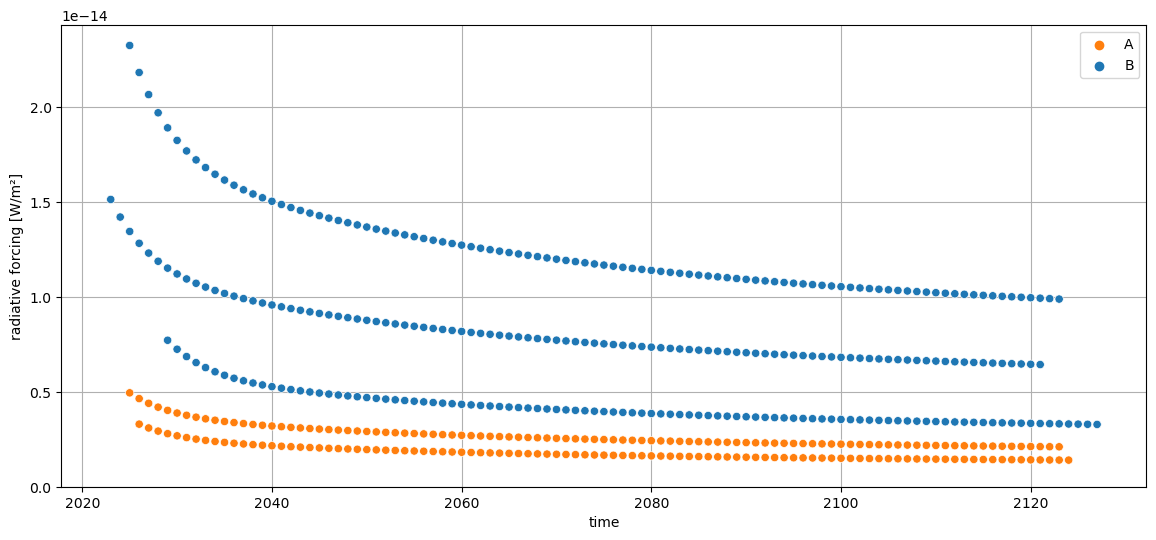

In [25]:
from dynamic_characterization.timex import characterize_co2
emission_id = bd.get_activity(("biosphere", "CO2")).id

characterization_function_dict = {
    emission_id: characterize_co2,
}

tlca.dynamic_lcia(
    metric="radiative_forcing",
    time_horizon=100,
    characterization_function_dict=characterization_function_dict,
)

tlca.plot_dynamic_characterized_inventory()

/Users/timodiepers/anaconda3/envs/timex/lib/python3.10/site-packages/dynamic_characterization/dynamic_characterization.py:262: UserWarning: Using bw_timex's default CO2 characterization function for GWP reference.
  warnings.warn(


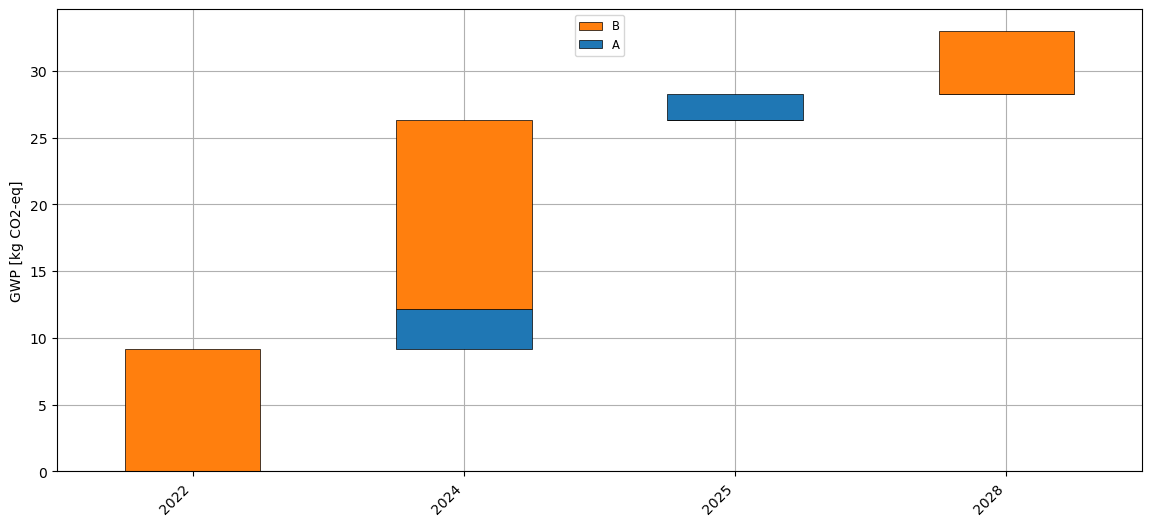

In [23]:
from bw_timex.utils import plot_characterized_inventory_as_waterfall

tlca.dynamic_lcia(
    metric="GWP",
    time_horizon=100,
    characterization_function_dict=characterization_function_dict,
)
plot_characterized_inventory_as_waterfall(tlca)


## Quick Recap
This might have seemed quite lengthy now. But essentially, calculating a `TimexLCA` is just this:

In [26]:
tlca = TimexLCA(
    demand={("foreground", "A"): 1},
    method=("our", "method"),
    database_date_dict=database_date_dict,
)
tlca.build_timeline()
tlca.lci()
tlca.static_lcia()
tlca.static_score

Starting graph traversal
Calculation count: 1


/Users/timodiepers/Documents/Coding/bw_timex/bw_timex/timex_lca.py:216: UserWarning: No edge filter function provided. Skipping all edges within background databases.
  warnings.warn(
/Users/timodiepers/anaconda3/envs/timex/lib/python3.10/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)


32.96019709827539

For most of the functions we used here, there are numerous optional arguments and settings you can tweak. We explore some of them in our other [Examples](https://docs.brightway.dev/projects/bw-timex/en/latest/content/examples/index.html), but when in doubt: Our code is pretty well documented, see our [API Reference](https://docs.brightway.dev/projects/bw-timex/en/latest/content/api/index.html) - so please browse through that as needed ☀️